In [1]:
import pandas as pd

## 载入数据与格式转换

In [2]:
data = pd.read_csv('./train.csv').drop('ID', axis=1)
data.head(3)

,Datetime,Count
0,25-08-2012 00:00,8
1,25-08-2012 01:00,2
2,25-08-2012 02:00,6


In [3]:
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d-%m-%Y %H:%M')
data.set_index('Datetime', drop=True, inplace=True)
data.head(3)

,Count
Datetime,
2012-08-25 00:00:00,8
2012-08-25 01:00:00,2
2012-08-25 02:00:00,6


In [4]:
daily_data = data.resample('D').sum()
daily_data.head()

,Count
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60


In [5]:
daily_data.reset_index(inplace=True)
daily_data.rename({'Datetime': 'ds', 'Count': 'y'}, axis=1, inplace=True)
daily_data.head(3)

,ds,y
0,2012-08-25,76
1,2012-08-26,88
2,2012-08-27,62


In [6]:
print(daily_data['ds'].min(), daily_data['ds'].max())

2012-08-25 00:00:00 2014-09-25 00:00:00


In [7]:
# 未来7个月有212天
pd.date_range(start='2014-09-26', end='2015-04-25')

DatetimeIndex(['2014-09-26', '2014-09-27', '2014-09-28', '2014-09-29',
               '2014-09-30', '2014-10-01', '2014-10-02', '2014-10-03',
               '2014-10-04', '2014-10-05',
               ...
               '2015-04-16', '2015-04-17', '2015-04-18', '2015-04-19',
               '2015-04-20', '2015-04-21', '2015-04-22', '2015-04-23',
               '2015-04-24', '2015-04-25'],
              dtype='datetime64[ns]', length=212, freq='D')

## 使用prophet进行预测

In [10]:
from fbprophet import Prophet

model = Prophet(growth='linear',weekly_seasonality=True, seasonality_prior_scale=0.5)
model.fit(daily_data)
future = model.make_future_dataframe(periods=212)
forecast = model.predict(future)
forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-08-25,-689.938840,-2387.320427,48.513089,-689.938840,-689.938840,-424.462986,-424.462986,-424.462986,-995.151123,-995.151123,-995.151123,570.688137,570.688137,570.688137,0.0,0.0,0.0,-1114.401826
1,2012-08-26,-681.815295,-2432.518290,-144.961245,-681.815295,-681.815295,-582.444698,-582.444698,-582.444698,-1144.228977,-1144.228977,-1144.228977,561.784280,561.784280,561.784280,0.0,0.0,0.0,-1264.259992
2,2012-08-27,-673.691749,-886.756120,1505.908433,-673.691749,-673.691749,1007.615094,1007.615094,1007.615094,457.600326,457.600326,457.600326,550.014768,550.014768,550.014768,0.0,0.0,0.0,333.923345
3,2012-08-28,-665.568203,-747.421493,1736.573455,-665.568203,-665.568203,1144.567325,1144.567325,1144.567325,608.378216,608.378216,608.378216,536.189110,536.189110,536.189110,0.0,0.0,0.0,478.999122
4,2012-08-29,-657.444658,-731.860878,1628.893930,-657.444658,-657.444658,1078.044704,1078.044704,1078.044704,556.908870,556.908870,556.908870,521.135835,521.135835,521.135835,0.0,0.0,0.0,420.600046


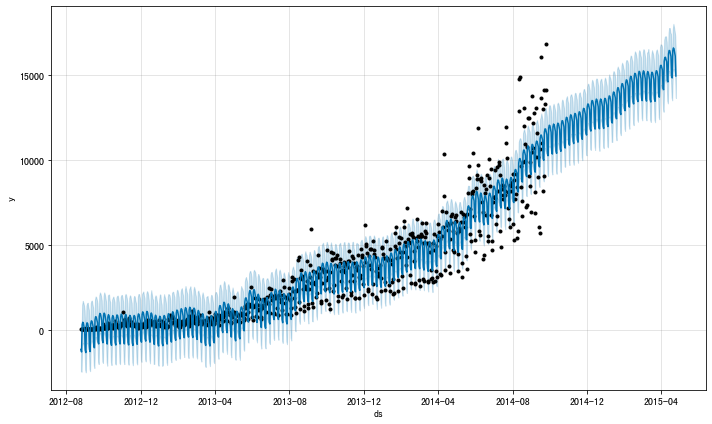

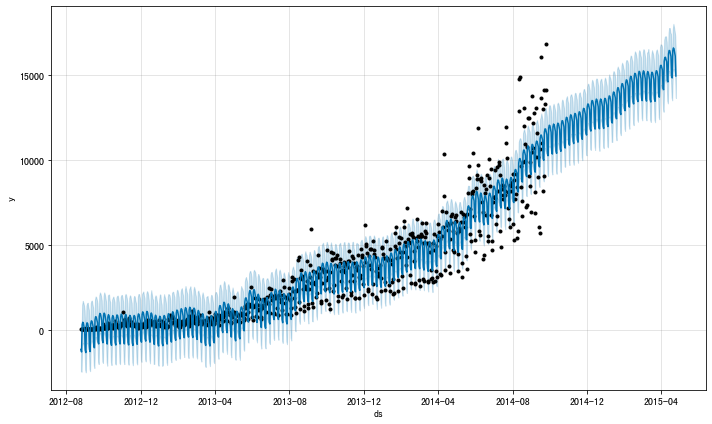

In [11]:
# 不明白为什么会画两张图
model.plot(forecast)

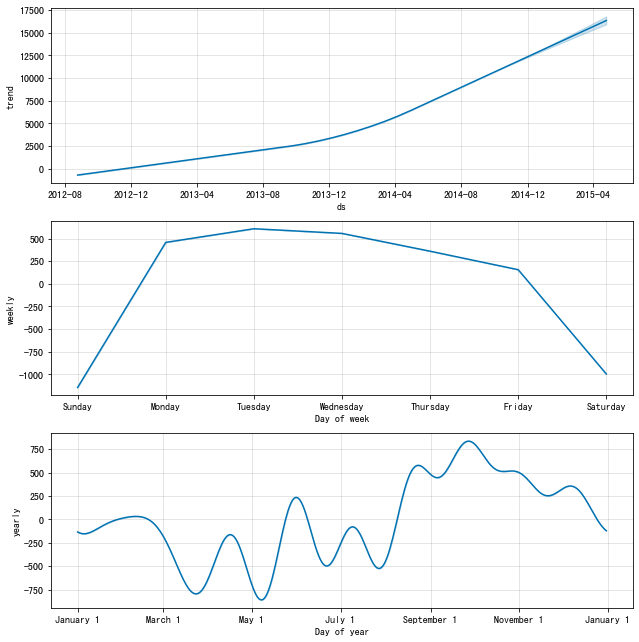

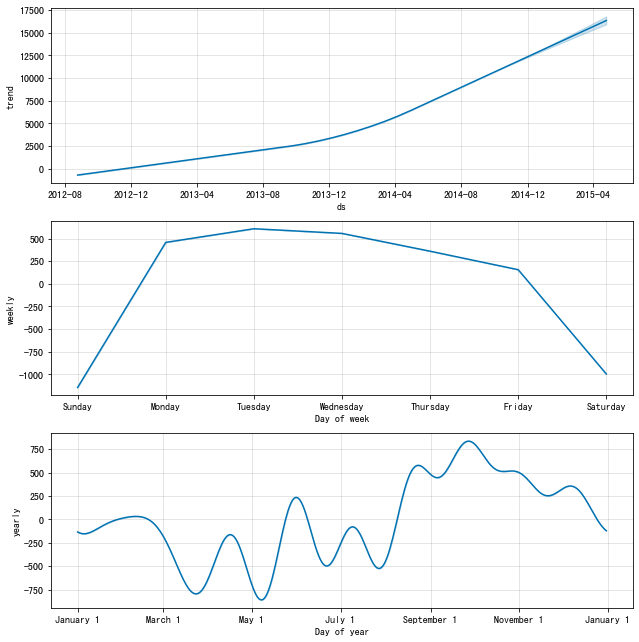

In [12]:
model.plot_components(forecast)

## 基于logistic函数进行预测
结果与上面的好像区别不大

In [23]:
model2 = Prophet(growth='logistic',weekly_seasonality=True, daily_seasonality=False, seasonality_prior_scale=0.005)
daily_data['cap'] = 20000
model2.fit(daily_data)
future2 = model2.make_future_dataframe(periods=212)
future2['floor'] = 0
future2['cap'] = 20000
forecast2 = model2.predict(future2)
forecast2.head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-08-25,276.830297,20000,-1327.192757,1170.247568,276.830297,276.830297,-357.540525,-357.540525,-357.540525,-740.310125,-740.310125,-740.310125,382.769600,382.769600,382.769600,0.0,0.0,0.0,-80.710227
1,2012-08-26,278.400791,20000,-1538.372922,1102.519741,278.400791,278.400791,-487.703223,-487.703223,-487.703223,-849.589844,-849.589844,-849.589844,361.886621,361.886621,361.886621,0.0,0.0,0.0,-209.302432
2,2012-08-27,279.980067,20000,-260.560105,2086.113810,279.980067,279.980067,677.970726,677.970726,677.970726,338.340682,338.340682,338.340682,339.630044,339.630044,339.630044,0.0,0.0,0.0,957.950793
3,2012-08-28,281.568174,20000,-229.402998,2242.811525,281.568174,281.568174,767.889595,767.889595,767.889595,451.153046,451.153046,451.153046,316.736549,316.736549,316.736549,0.0,0.0,0.0,1049.457769
4,2012-08-29,283.165160,20000,-334.078918,2202.138382,283.165160,283.165160,708.066548,708.066548,708.066548,414.128469,414.128469,414.128469,293.938079,293.938079,293.938079,0.0,0.0,0.0,991.231708


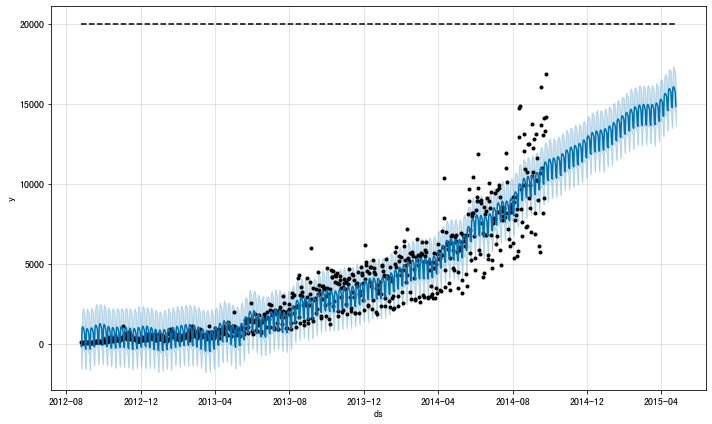

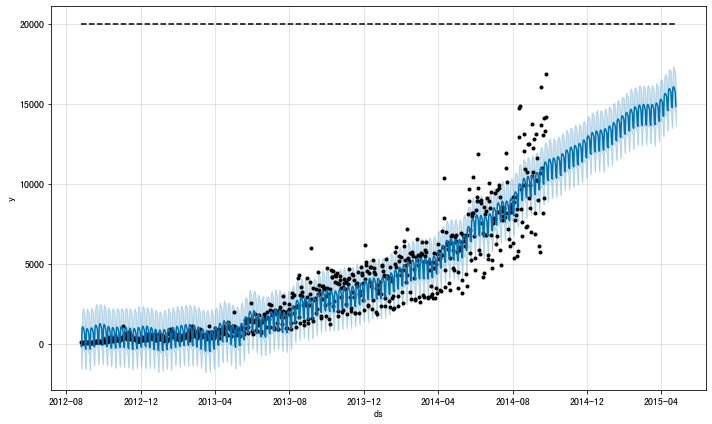

In [24]:
model2.plot(forecast2)

In [20]:
pd.concat([forecast['yhat'], forecast2['yhat']], axis=1)

,yhat,yhat
0,-1114.401826,-208.664474
1,-1264.259992,-384.615273
2,333.923345,1188.356518
3,478.999122,1309.202818
4,420.600046,1227.835304
...,...,...
969,16606.882346,16206.667333
970,16551.708681,16147.666555
971,16346.197126,15937.974785
972,16128.294486,15713.625133
